In [ ]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import os

In [ ]:
os.listdir("../input/patreco3-multitask-affective-music/data/")

['multitask_dataset_beat',
 'fma_genre_spectrograms',
 'fma_genre_spectrograms_beat',
 'multitask_dataset']

In [ ]:
import pandas as pd
labels = pd.read_csv("../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt", sep=" ")
labels = pd.DataFrame.to_numpy(labels)
print(labels.shape)

**choose 2 labels**

In [ ]:
def get_index(s):
    return s[0].split(".")[0], s[0].split(".")[-1].split('\t')[1]

idx1, genre1 = get_index(labels[1910])
idx2, genre2 = get_index(labels[3])
idx3, genre3 = get_index(labels[600])

print(idx1, idx2, idx3)
print(genre1, genre2, genre3)

In [ ]:
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/' +idx1+'.fused.full.npy')
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/'+idx2+'.fused.full.npy')
spec3 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/'+idx3+'.fused.full.npy')

**The shape is (mel + chroma frequencies, timesteps)**

In [ ]:
print(spec1.shape)
print(spec2.shape)

**decomposing into mel spectrogram and chromagram**

In [ ]:
mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]
mel3, chroma3 = spec3[:128], spec3[128:]

In [ ]:
print(mel1.shape, chroma1.shape)

In [ ]:
#ploting the Spectograms
plt.plot()
plt.close()
fig, ax = plt.subplots()
img = librosa.display.specshow(mel1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of genre: ' + genre1)
#fig.colorbar(img, ax=ax, format="%+2.f dB")
#black -> -80dB

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of genre: ' + genre2)
#fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel3, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of genre: ' + genre3)
#fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/' +idx1+'.fused.full.npy')
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/'+idx2+'.fused.full.npy')

mel1, chroma1 = spec1[:128], spec1[128:]
mel2, chroma2 = spec2[:128], spec2[128:]

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-Synced Spectrogram of genre: ' + genre1)
#fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mel2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-Synced Spectrogram of genre: ' + genre2)
#fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


# Helper functions to read fused, mel, and chromagram
def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T


def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


In [ ]:
# TODO: Comment on how the train and validation splits are created.
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    # Creating a list of all indices in dataset
    indices = list(range(dataset_size))
    # Calculate the number of validation data
    val_split = int(np.floor(val_size * dataset_size))
    # Shuffle the indices
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    # Split the indices for training and validation set according to the calculated number of val data
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
# class that pads object with zeros or cross it to max_length
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

# Pytorch Dataset Class for creating the dataset
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        # Construct the path to label text file
        p = os.path.join(path, t)
        self.full_path = p
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        # get training or test files and also their label
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        # load spectrogram or chomagram or both from eaxh file
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        # keep length for each datum and max _length in dataset
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        # zero padd data to max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        # trasform labels to numbers
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            # map label according to class mapping
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            fname = l[0]
            if fname.endswith(".gz"):
                fname = ".".join(fname.split(".")[:-1])
            if 'fma_genre_spectrograms_beat' in self.full_path.split('/'): # necessary fix 1
                fname = fname.replace('beatsync.fused', 'fused.full')
            if 'test' in self.full_path.split('/'): # necessary fix 2
                fname = fname.replace('full.fused', 'fused.full')
            files.append(fname)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        # output = padded feature eg 128 * max_length for spectrogram, label, original feat lenght
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)

In [ ]:
#  create a dataset for spectrograms
path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/'
beat_mel_specs_wo = SpectrogramDataset(
         path,
         train=True,
         class_mapping=None,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
# get labels for data without mapping classes
_, ll = beat_mel_specs_wo.get_files_labels(path + 'train_labels.txt', None)
# get labels for data mapping classes as class mapping propose
_, ll_ = beat_mel_specs_wo.get_files_labels(path + 'train_labels.txt', class_mapping)

In [ ]:
import pandas
from collections import Counter
# Plot histograms before and after mapping
genre_c = Counter(ll)
df = pandas.DataFrame.from_dict(genre_c, orient='index')
ax = df.plot(kind='bar', title = 'before mapping', figsize=(28,10))
ax.figure.savefig('before.png')

genre_c = Counter(ll_)
df = pandas.DataFrame.from_dict(genre_c, orient='index')
ax = df.plot(kind='bar', title = 'after mapping', figsize=(28,10))
ax.figure.savefig('after.png')

**LSTM.py**

In [ ]:
# A full LSTM implementation is provided
# You can use this or the one you implemented in the second lab

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PadPackedSequence(nn.Module):
    def __init__(self):
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PadPackedSequence, self).__init__()
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first=self.batch_first, total_length=self.max_length  # type: ignore
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out


class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=1,
        bidirectional=False,
        dropout=0.1,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        return last_timestep

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out

In [ ]:
import sys
sys.path.insert(1, '/kaggle/input/lstm-b')
#from lstm import LSTMBackbone
from sklearn.metrics import accuracy_score, confusion_matrix
#from modules import Classifier, MultitaskRegressor, Regressor


class EarlyStopping(object):
    def __init__(self, patience, mode="min", base=np.Inf):
        self.best = base
        self.patience = patience
        self.patience_left = patience
        self.mode = mode

    def stop(self, model, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Decrease patience if the metric hs not improved
        # Stop when patience reaches zero
        if not self.has_improved(value):
            self.patience_left-=1
        else:
            #keep the best value of the metric so far
            self.best = value
            #save the model with the best metric so far
            self.checkpoint(model)
        #if there is no patience left stop training process
        return self.patience_left == 0
    #A function to save best models parameters during training
    def checkpoint(self, model):
        torch.save(model.state_dict(), 'best_model.pth')

    #A function to load parameters of the best model during training
    def resume(self, model):
        model.load_state_dict(torch.load('best_model.pth'))

    def has_improved(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Check if the metric has improved
        return value < self.best


def training_loop(model, train_dataloader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch in train_dataloader:
        features, labels, lengths = batch
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        lengths = lengths.to(device)
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        outputs = model.forward(features.float(), lengths)
        # calculate loss
        loss = criterion(outputs, labels)
        # Run backward pass
        loss.backward()
        # Update the parameteres
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    #y_pred = torch.empty(0, dtype=torch.int64)
    #y_true = torch.empty(0, dtype=torch.int64)
    y_pred = torch.empty(0, dtype=torch.int64, device=device)
    y_true = torch.empty(0, dtype=torch.int64, device=device)
    with torch.no_grad():
        for num_batch, batch in enumerate(val_dataloader):
            features, labels, lengths = batch
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)
            # TODO: YOUR CODE HERE
            # Run forward pass
            logits = model.forward(features.float(), lengths)
            # calculate loss
            loss = criterion(logits, labels)
            running_loss += loss.item()
            # Predict
            outputs = torch.argmax(logits, dim = 1)# Calculate the argmax of logits
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches

    return valid_loss, y_pred, y_true  # Return validation_loss and anything else you need


def overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion):
    epochs = 5000  # An absurd number of epochs
    # TODO: select a couple of batches from the dataloader
    batches = [next(iter(train_dataloader)) for i in range(2)]
    # TODO: Run the training loop for an absurd amount of epochs
    for epoch in range(epochs):
        training_loss = training_loop(model, batches, optimizer, criterion)
        if epoch%1000 is 0:
            print("Epoch:", epoch)
    b_loss, y_pred, y_true = validation_loop(model, batches, criterion)
    y_pred = torch.tensor(y_pred, device='cpu')
    y_true = torch.tensor(y_true, device='cpu')
    b_accuracy = accuracy_score(y_true, y_pred)
    print("Batch overfitting: loss = {}, acc = {}".format(b_loss, b_accuracy))


def train(model, train_dataloader, val_dataloader, optimizer, epochs, criterion, device="cuda", overfit_batch=False, patience = 20):
    t_loss = []
    val_loss = []
    val_acc = []
    model = model.to(device).float()
    early_stopping = EarlyStopping(patience, mode="min")
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion)
    else:
        for epoch in range(epochs):
            training_loss = training_loop(model, train_dataloader, optimizer, criterion)
            valid_loss, y_pred, y_true = validation_loop(model, val_dataloader, criterion)

            # TODO: Calculate and print accuracy score
            y_pred = torch.tensor(y_pred, device='cpu')
            y_true = torch.tensor(y_true, device='cpu')
            valid_accuracy = accuracy_score(y_true, y_pred)
            print(
                "Epoch {}: train loss = {}, valid loss = {}, valid acc = {}".format(
                    epoch, training_loss, valid_loss, valid_accuracy
                )
            )
            t_loss.append(training_loss)
            val_loss.append(valid_loss)
            val_acc.append(valid_accuracy)
            #check early stop criterion if early_stp is True
            if early_stp and early_stopping.stop(model, valid_loss):
                print("early stopping... ", epoch)
                early_stopping.resume(model)
                break
    #return trained model and losses during training
    return model, t_loss, val_loss, val_acc

In [ ]:
path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/'

# construct dataset
mel_specs = SpectrogramDataset(
         path,
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
#split dataset to train, val
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.2)

# construct test dataset
test_loader = SpectrogramDataset(
     path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)

# fix model hyperparameters
input_dim = train_loader_mel.dataset.feats[0].shape[-1]
rnn_size = 128
output_dim = len(np.unique(train_loader_mel.dataset.labels)) # number of genres
num_layers = 2
bidirectional = False
dropout = 0.1
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = True

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Epoch 0: train loss = 2.2654786644310785, valid loss = 2.2324947357177733, valid acc = 0.18872017353579176
Epoch 1: train loss = 2.206927480368779, valid loss = 2.1977300961812336, valid acc = 0.21691973969631237
Epoch 2: train loss = 2.1716250016771514, valid loss = 2.150477925936381, valid acc = 0.23210412147505424
Epoch 3: train loss = 2.1242229178034027, valid loss = 2.127933971087138, valid acc = 0.21691973969631237
Epoch 4: train loss = 2.1624161827153174, valid loss = 2.1540499051411945, valid acc = 0.20824295010845986
Epoch 5: train loss = 2.0951263945678185, valid loss = 2.028818901379903, valid acc = 0.27331887201735355
Epoch 6: train loss = 2.0248371670986045, valid loss = 1.9968175729115805, valid acc = 0.2668112798264642
Epoch 7: train loss = 2.006832344778653, valid loss = 1.9648905754089356, valid acc = 0.2885032537960954
Epoch 8: train loss = 2.0962795882389464, valid loss = 2.3377018928527833, valid acc = 0.1301518438177874
Epoch 9: train loss = 2.1174719765268524, val

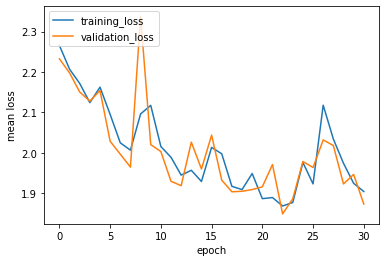

In [ ]:
model_f = LSTMBackbone(
                input_dim,
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_f.parameters(),  lr=lr, weight_decay=weight_decay)

#train model
model_f, t_loss, val_loss, val_acc =train(model_f,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

In [ ]:
# Report metrics on trained model
from sklearn.metrics import classification_report

test_loss, y_pred, y_true = validation_loop(model_f, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print(classification_report(y_true, y_pred))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.35      0.55      0.43        40
           2       0.26      0.78      0.39        80
           3       0.38      0.45      0.41        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.44      0.46      0.45        78
           7       0.00      0.00      0.00        40
           8       0.38      0.37      0.37       103
           9       0.00      0.00      0.00        34

    accuracy                           0.34       575
   macro avg       0.18      0.26      0.21       575
weighted avg       0.24      0.34      0.27       575



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# try to overfit on a couple of batches from dataset to examine if the model has the expressive
# capability for solving the problem
t = train(model_f,train_loader_mel, val_loader_mel, optimizer, epochs, criterion, device = 'cuda', overfit_batch = True)


# ### Train second model with beat syncronized mel spectrograms. The model is faster since features lie in far less dimensions


In [ ]:
path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/'

# construct dataset
beat_mel_specs = SpectrogramDataset(
         path,
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)

#split dataset to train, val
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.2)

# construct test dataset
test_loader = SpectrogramDataset(
     path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)

# fix model hyperparameters
input_dim = train_loader_beat_mel.dataset.feats[0].shape[-1]

In [ ]:
model_f_beat = LSTMBackbone(
                input_dim,
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_f_beat.parameters(),  lr=lr, weight_decay=weight_decay)

# train model
model_f_beat, t_loss, val_loss, val_acc =train(model_f_beat,train_loader_beat_mel, val_loader_beat_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()


In [ ]:
# Report metrics on trained model

test_loss, y_pred, y_true = validation_loop(model_f_beat, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print(classification_report(y_true, y_pred))

In [ ]:
# batch overfitting
t = train(model_f_beat,train_loader_beat_mel, val_loader_beat_mel, optimizer, epochs, criterion, device = 'cuda', overfit_batch = True)


# ### Train third model with chromatograms. The model is the fastest, but unable to learn classifing data

In [ ]:
path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/'

# construct dataset
beat_chrom_specs = SpectrogramDataset(
         path,
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

# construct test dataset
test_loader = SpectrogramDataset(
     path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_chromagram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)

#split dataset to train, val
train_loader_chrom, val_loader_chrom = torch_train_val_split(beat_chrom_specs, 32 ,32, val_size=.2)

# fix model hyperparameters
input_dim = train_loader_chrom.dataset.feats[0].shape[-1]
le = 1e-5

In [ ]:
# define model according to given code
model_chrom = LSTMBackbone(
                input_dim,
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_chrom.parameters(),  lr=lr, weight_decay=weight_decay)

# train model
model_chrom, t_loss, val_loss, val_acc =train(model_chrom,train_loader_chrom, val_loader_chrom, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

In [ ]:
# Report metrics on trained model
test_loss, y_pred, y_true = validation_loop(model_chrom, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print(classification_report(y_true, y_pred))

In [ ]:
# batch overfitting
t = train(model_chrom,train_loader_chrom, val_loader_chrom, optimizer, epochs, criterion, device = 'cuda', overfit_batch = True)

 # ***Main Part***

In [ ]:
import torch
import torch.nn as nn

# CNN definition

class CNNBackbone(nn.Module):

    def __init__(self, H, W):

        super(CNNBackbone, self).__init__()
        self.a = H
        self.b = W
        for i in range(4):
            self.a = ((self.a-6)//2) + 1
            self.b = ((self.b-6)//2) + 1

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.fc1 = nn.Linear(self.a*self.b*256, 10)  #78848
        self.dropout = nn.Dropout2d(p=0.1)

    #(n_samples, channels, height, width)
    def forward(self, x, lengths):
        x = x.unsqueeze(1)
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = self.fc1(output)
        return output

In [ ]:
# Train first model with mel spectrograms without beat sync

path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/'

# construct dataset
mel_specs = SpectrogramDataset(
         path,
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
#split dataset to train, val
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.2)

# construct test dataset
test_loader = SpectrogramDataset(
     path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = True
input_dim = train_loader_mel.dataset.feats[0].shape

In [ ]:
# define model according to given code

model_f = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_f.parameters(),  lr=lr, weight_decay=weight_decay)

In [ ]:
# try to overfit on a couple of batches from dataset to examine if the model has the expressive
# capability for solving the problem
print("Overfitting Model 1...")
model_f, t_loss, val_loss, val_acc = train(model_f,train_loader_mel, val_loader_mel, optimizer, epochs, criterion, device = 'cuda', overfit_batch = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Epoch 0: train loss = 2.716868875355556, valid loss = 2.2240768829981485, valid acc = 0.3080260303687636
Epoch 1: train loss = 1.7441944747135556, valid loss = 2.0055235862731933, valid acc = 0.31453362255965295
Epoch 2: train loss = 1.3447378462758557, valid loss = 2.2083637873331705, valid acc = 0.3470715835140998
Epoch 3: train loss = 0.9925644644375505, valid loss = 2.110916336377462, valid acc = 0.351409978308026
Epoch 4: train loss = 0.5557106728183812, valid loss = 2.1519459009170534, valid acc = 0.3383947939262473
Epoch 5: train loss = 0.3895577395270611, valid loss = 1.9254561026891073, valid acc = 0.3362255965292842
Epoch 6: train loss = 0.24572300551266507, valid loss = 1.8336304585138956, valid acc = 0.3882863340563991
Epoch 7: train loss = 0.15188057271057162, valid loss = 1.8356951157251993, valid acc = 0.3882863340563991
Epoch 8: train loss = 0.11879390760742385, valid loss = 1.839079785346985, valid acc = 0.37093275488069416
Epoch 9: train loss = 0.07419076317857051, va

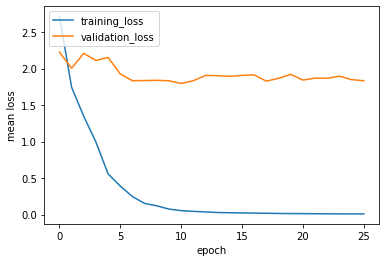

In [ ]:
#train model

model_f, t_loss, val_loss, val_acc = train(model_f,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

In [ ]:
# Report metrics on trained model
from sklearn.metrics import classification_report

test_loss, y_pred, y_true = validation_loop(model_f, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print(classification_report(y_true, y_pred))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.15      0.12      0.14        40
           1       0.51      0.65      0.57        40
           2       0.78      0.40      0.53        80
           3       0.39      0.47      0.43        80
           4       0.49      0.45      0.47        40
           5       0.19      0.10      0.13        40
           6       0.47      0.56      0.51        78
           7       0.23      0.20      0.21        40
           8       0.32      0.40      0.36       103
           9       0.29      0.32      0.31        34

    accuracy                           0.39       575
   macro avg       0.38      0.37      0.37       575
weighted avg       0.41      0.39      0.39       575



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Regression

In [ ]:
#STEP 8

def torch_train_val_test_split(dataset, batch_train, batch_eval, batch_test,
                            val_size=.15, test_size=.15, shuffle=True, seed=None):

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    test_split = int(np.floor(test_size * dataset_size))

    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)

    train_indices = indices[test_split+val_split:]
    val_indices = indices[:val_split]
    test_indices = indices[val_split:test_split+val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    test_loader = DataLoader(dataset,
                            batch_size=1,
                            sampler=test_sampler)

    return train_loader, val_loader, test_loader

In [ ]:
def training_loop(model, train_dataloader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch in train_dataloader:
        features, labels, lengths = batch
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.float, device=device)
        lengths = lengths.to(device)
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        outputs = model.forward(features.float(), lengths)
        # calculate loss
        loss = criterion(outputs, labels)
        # Run backward pass
        loss.backward()
        # Update the parameteres
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    #y_pred = torch.empty(0, dtype=torch.int64)
    #y_true = torch.empty(0, dtype=torch.int64)
    y_pred = torch.empty(0, dtype=torch.float, device=device)
    y_true = torch.empty(0, dtype=torch.float, device=device)
    with torch.no_grad():
        for num_batch, batch in enumerate(val_dataloader):
            features, labels, lengths = batch
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.float, device=device)
            lengths = lengths.to(device)
            # TODO: YOUR CODE HERE
            # Run forward pass
            outputs = model.forward(features.float(), lengths)
            # calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # Predict
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches
    return valid_loss, y_pred, y_true  # Return validation_loss and anything else you need


def train(model, train_dataloader, val_dataloader, optimizer, epochs, criterion, device="cuda", overfit_batch=False, patience = 20):
    t_loss = []
    val_loss = []
    model = model.to(device).float()
    early_stopping = EarlyStopping(patience, mode="min")
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion)
    else:
        for epoch in range(epochs):
            training_loss = training_loop(model, train_dataloader, optimizer, criterion)
            valid_loss, y_pred, y_true = validation_loop(model, val_dataloader, criterion)

            print(
                "Epoch {}: train loss = {}, valid loss = {}".format(
                    epoch, training_loss, valid_loss
                )
            )
            t_loss.append(training_loss)
            val_loss.append(valid_loss)
            #check early stop criterion if early_stp is True
            if early_stp and early_stopping.stop(model, valid_loss):
                print("early stopping... ", epoch)
                early_stopping.resume(model)
                break
    #return trained model and losses during training
    return model, t_loss, val_loss


In [ ]:
# Pytorch Dataset Class for creating the MultiTask dataset
class MultitaskDataset(Dataset):
    def __init__(self, path, attr, train=True, max_length=-1, clsss_mapping=None, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        # Construct the path to label text file
        p = os.path.join(path, t)
        self.full_path = p
        self.attr = attr
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        # get training or test files and also their label
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        # load spectrogram or chomagram or both from eaxh file
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        # keep length for each datum and max _length in dataset
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        # zero padd data to max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        # trasform labels to numbers
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            l = l[0].split(',')
            if(self.attr==3): label = l[self.attr].strip('\n')
            else: label = l[self.attr]
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            fname = int(l[0])
            npy_file = '{}.fused.full.npy'.format(fname)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        # output = padded feature eg 128 * max_length for spectrogram, label, original feat lenght
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)


In [ ]:
import torch
import torch.nn as nn

# LSTM modification for regression

class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=1,
        bidirectional=False,
        dropout=0.1,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(self.feature_size, output_dim)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        output = self.fc(last_timestep)
        return output

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out

In [ ]:
import torch
import torch.nn as nn

# CNN modification for regression

class CNNBackbone(nn.Module):

    def __init__(self, H, W):

        super(CNNBackbone, self).__init__()
        self.a = H
        self.b = W
        for i in range(4):
            self.a = ((self.a-6)//2) + 1
            self.b = ((self.b-6)//2) + 1

        super(CNNBackbone, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.fc1 = nn.Linear(self.a*self.b*256, 1)
        self.dropout = nn.Dropout2d(p=0.1)

    #(n_samples, channels, height, width)
    def forward(self, x, lengths):
        x = x.unsqueeze(1)
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = self.fc1(output)
        return output

In [ ]:
# define score arrays

score_LSTM = []
score_CNN = []

# Valence

In [ ]:
path = path = '../input/patreco3-multitask-affective-music/data/multitask_dataset/'

mel_specs = MultitaskDataset(
    path,
    attr = 1,
    train=True,
    max_length=-1,
    read_spec_fn=read_mel_spectrogram)

train_loader_mel, val_loader_mel, test_loader = torch_train_val_test_split(mel_specs, 32 ,32, 32, val_size=.1, test_size=.1)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = False
input_dim = train_loader_mel.dataset.feats[0].shape
#
rnn_size = 128
num_layers = 2
bidirectional = False
dropout = 0.1
output_dim = 1

In [ ]:
# define model according to given code
model_lstm_reg = LSTMBackbone(
                input_dim[-1],
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_lstm_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/

Epoch 0: train loss = 0.13573036201555153, valid loss = 0.08122135885059834
Epoch 1: train loss = 0.06717843536672921, valid loss = 0.07610257714986801
Epoch 2: train loss = 0.06532253235064704, valid loss = 0.07163525559008121
Epoch 3: train loss = 0.06993370374728894, valid loss = 0.07354303076863289
Epoch 4: train loss = 0.06655392577422076, valid loss = 0.071339787915349
Epoch 5: train loss = 0.06544789350752173, valid loss = 0.07308230176568031
Epoch 6: train loss = 0.06648159618007726, valid loss = 0.07344532385468483
Epoch 7: train loss = 0.06632664388623731, valid loss = 0.073007982224226
Epoch 8: train loss = 0.06482926409306197, valid loss = 0.07087559066712856
Epoch 9: train loss = 0.06387204188725044, valid loss = 0.07210982777178288
Epoch 10: train loss = 0.06669546715144453, valid loss = 0.07372546382248402
Epoch 11: train loss = 0.06663290398388073, valid loss = 0.0740054864436388
Epoch 12: train loss = 0.06499430447303016, valid loss = 0.073721157386899
Epoch 13: train 

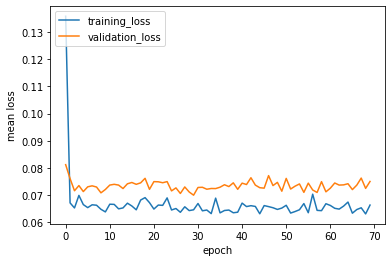

In [ ]:
#train model

model_lstm_reg, t_loss, val_loss = train(model_lstm_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.2315339
MSE:  0.07194029
Spearman correlation (Valence, LSTM):  -0.0422618526452527


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

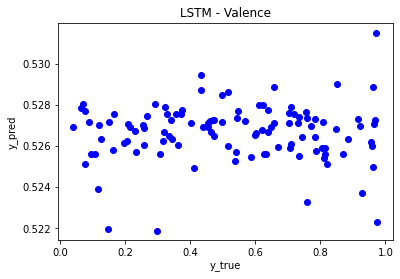

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_lstm_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_LSTM.append(sp)
print("Spearman correlation (Valence, LSTM): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("LSTM - Valence")
plt.xlabel("y_true")
plt.ylabel("y_pred")

In [ ]:
# define model according to given code

model_cnn_reg = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_cnn_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/

Epoch 0: train loss = 4.651946077572888, valid loss = 1.033594325184822
Epoch 1: train loss = 0.48717443593617143, valid loss = 0.28419309854507446
Epoch 2: train loss = 0.1692559415924138, valid loss = 0.14171955548226833
Epoch 3: train loss = 0.14851503973377161, valid loss = 0.14266564138233662
Epoch 4: train loss = 0.17665116771541792, valid loss = 0.13143885508179665
Epoch 5: train loss = 0.15693720738435613, valid loss = 0.12010250054299831
Epoch 6: train loss = 0.12848028617686238, valid loss = 0.1388833336532116
Epoch 7: train loss = 0.13198763389011908, valid loss = 0.11170726642012596
Epoch 8: train loss = 0.11527100205421448, valid loss = 0.10307031683623791
Epoch 9: train loss = 0.1155238614000123, valid loss = 0.1218832153826952
Epoch 10: train loss = 0.11907188080508134, valid loss = 0.1318872682750225
Epoch 11: train loss = 0.12142437542306966, valid loss = 0.1321987435221672
Epoch 12: train loss = 0.14895127944905182, valid loss = 0.14971894025802612
Epoch 13: train los

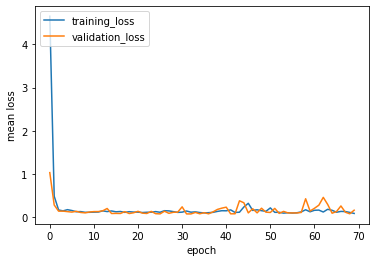

In [ ]:
#train model

model_cnn_reg, t_loss, val_loss = train(model_cnn_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.3170012
MSE:  0.14148627
Spearman correlation (Valence, CNN):  0.1706124297014054


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

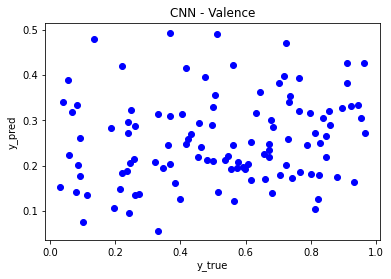

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_cnn_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_CNN.append(sp)
print("Spearman correlation (Valence, CNN): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN - Valence")
plt.xlabel("y_true")
plt.ylabel("y_pred")

# Energy

In [ ]:
path = path = '../input/patreco3-multitask-affective-music/data/multitask_dataset/'

mel_specs = MultitaskDataset(
    path,
    attr = 2,
    train=True,
    max_length=-1,
    read_spec_fn=read_mel_spectrogram)

train_loader_mel, val_loader_mel, test_loader = torch_train_val_test_split(mel_specs, 32 ,32, 32, val_size=.1, test_size=.1)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = False
input_dim = train_loader_mel.dataset.feats[0].shape
#
rnn_size = 128
num_layers = 2
bidirectional = False
dropout = 0.1
output_dim = 1

In [ ]:
# define model according to given code
model_lstm_reg = LSTMBackbone(
                input_dim[-1],
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_lstm_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/

Epoch 0: train loss = 0.206914016270432, valid loss = 0.07834404055029154
Epoch 1: train loss = 0.07228037278200018, valid loss = 0.0758640905842185
Epoch 2: train loss = 0.06683260228099494, valid loss = 0.06880849320441484
Epoch 3: train loss = 0.06667599030609789, valid loss = 0.07407891564071178
Epoch 4: train loss = 0.07221517621957023, valid loss = 0.073198352009058
Epoch 5: train loss = 0.0675797479162956, valid loss = 0.07730190642178059
Epoch 6: train loss = 0.06576328673239412, valid loss = 0.08339415956288576
Epoch 7: train loss = 0.06879055410109718, valid loss = 0.07305544055998325
Epoch 8: train loss = 0.06722180532484219, valid loss = 0.0714329369366169
Epoch 9: train loss = 0.06818293625938482, valid loss = 0.07441320829093456
Epoch 10: train loss = 0.06619649033608108, valid loss = 0.07483333628624678
Epoch 11: train loss = 0.06771473368180209, valid loss = 0.07462579756975174
Epoch 12: train loss = 0.06570046725843487, valid loss = 0.07500922679901123
Epoch 13: train 

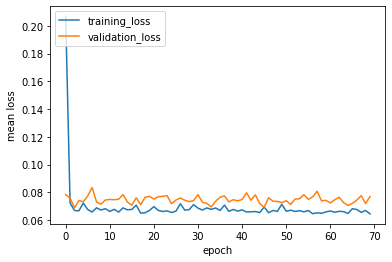

In [ ]:
#train model

model_lstm_reg, t_loss, val_loss = train(model_lstm_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.20689525
MSE:  0.06566645
Spearman correlation (Energy, LSTM):  0.28859238127708053


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

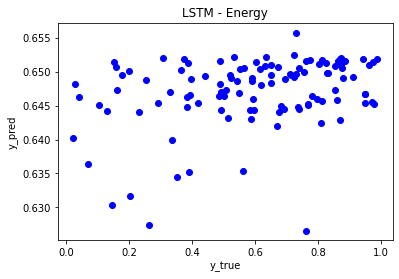

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_lstm_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_LSTM.append(sp)
print("Spearman correlation (Energy, LSTM): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("LSTM - Energy")
plt.xlabel("y_true")
plt.ylabel("y_pred")

In [ ]:
# define model according to given code

model_cnn_reg = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_cnn_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/

Epoch 0: train loss = 5.089432266765628, valid loss = 1.1082800030708313
Epoch 1: train loss = 0.557198703289032, valid loss = 0.26930660381913185
Epoch 2: train loss = 0.19274639929163045, valid loss = 0.15437427535653114
Epoch 3: train loss = 0.18129545861277088, valid loss = 0.15484106913208961
Epoch 4: train loss = 0.20965261500457238, valid loss = 0.21748929470777512
Epoch 5: train loss = 0.13946468588607064, valid loss = 0.11055847629904747
Epoch 6: train loss = 0.12913568189431882, valid loss = 0.1037696972489357
Epoch 7: train loss = 0.11990238957363984, valid loss = 0.1256239339709282
Epoch 8: train loss = 0.11926136114474001, valid loss = 0.12886481545865536
Epoch 9: train loss = 0.11463217732721362, valid loss = 0.11673955619335175
Epoch 10: train loss = 0.11839365471025994, valid loss = 0.2851403057575226
Epoch 11: train loss = 0.17658440614568777, valid loss = 0.11310025118291378
Epoch 12: train loss = 0.13497994326311966, valid loss = 0.22930185496807098
Epoch 13: train l

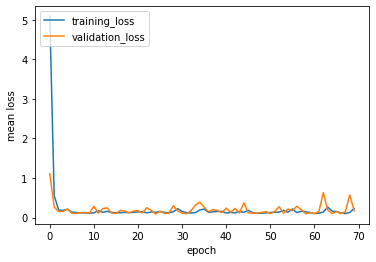

In [ ]:
#train model

model_cnn_reg, t_loss, val_loss = train(model_cnn_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.26992825
MSE:  0.10265795
Spearman correlation (Energy, CNN):  0.436781658324093


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

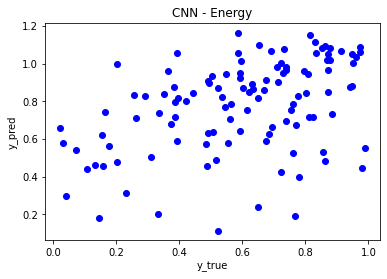

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_cnn_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_CNN.append(sp)
print("Spearman correlation (Energy, CNN): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN - Energy")
plt.xlabel("y_true")
plt.ylabel("y_pred")

# Danceability

In [ ]:
path = path = '../input/patreco3-multitask-affective-music/data/multitask_dataset/'

mel_specs = MultitaskDataset(
    path,
    attr = 3,
    train=True,
    max_length=-1,
    read_spec_fn=read_mel_spectrogram)

train_loader_mel, val_loader_mel, test_loader = torch_train_val_test_split(mel_specs, 32 ,32, 32, val_size=.05, test_size=.05)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = False
input_dim = train_loader_mel.dataset.feats[0].shape
#
rnn_size = 128
num_layers = 2
bidirectional = False
dropout = 0.1
output_dim = 1

In [ ]:
# define model according to given code
model_lstm_reg = LSTMBackbone(
                input_dim[-1],
                rnn_size,
                num_layers,
                bidirectional=bidirectional,
                dropout=dropout,
            )

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_lstm_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/

Epoch 0: train loss = 0.06785600439741693, valid loss = 0.030319122597575188
Epoch 1: train loss = 0.03373539788198882, valid loss = 0.027332895901054144
Epoch 2: train loss = 0.03359427457225734, valid loss = 0.027171025052666664
Epoch 3: train loss = 0.032769173319483626, valid loss = 0.0266333376057446
Epoch 4: train loss = 0.03467962319224045, valid loss = 0.026469743810594082
Epoch 5: train loss = 0.03277919362780863, valid loss = 0.030029898043721914
Epoch 6: train loss = 0.03615731739535414, valid loss = 0.024653164902701974
Epoch 7: train loss = 0.03342243579441104, valid loss = 0.0257476307451725
Epoch 8: train loss = 0.03347016742517208, valid loss = 0.027226940728724003
Epoch 9: train loss = 0.03384468010787306, valid loss = 0.025096321012824774
Epoch 10: train loss = 0.032385006979517315, valid loss = 0.02952519664540887
Epoch 11: train loss = 0.03317628331996243, valid loss = 0.027765108738094568
Epoch 12: train loss = 0.03364975165961118, valid loss = 0.02617515716701746


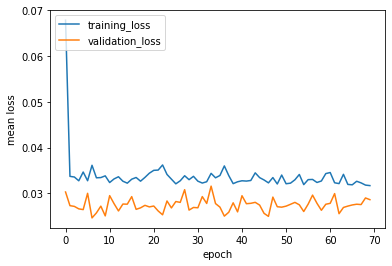

In [ ]:
#train model

model_lstm_reg, t_loss, val_loss = train(model_lstm_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.12522058
MSE:  0.023779018
Spearman correlation (Danceability, LSTM):  0.3022985144002603


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

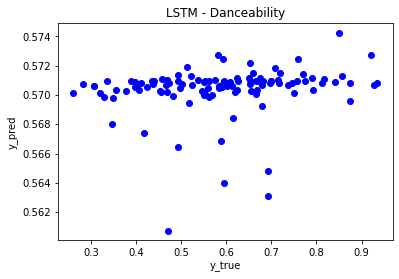

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_lstm_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_LSTM.append(sp)
print("Spearman correlation (Danceability, LSTM): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("LSTM - Danceability")
plt.xlabel("y_true")
plt.ylabel("y_pred")

In [ ]:
# define model according to given code
model_cnn_reg = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_cnn_reg.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.

Epoch 0: train loss = 5.4481591591611505, valid loss = 0.08493534848093987
Epoch 1: train loss = 0.4116361786145717, valid loss = 0.1652722880244255
Epoch 2: train loss = 0.14346603932790458, valid loss = 0.08171393722295761
Epoch 3: train loss = 0.12231601239182055, valid loss = 0.10232638940215111
Epoch 4: train loss = 0.10526288242544979, valid loss = 0.0769004113972187
Epoch 5: train loss = 0.09081039670854807, valid loss = 0.07325186394155025
Epoch 6: train loss = 0.089765380253084, valid loss = 0.06863314285874367
Epoch 7: train loss = 0.08397290227003396, valid loss = 0.10807308927178383
Epoch 8: train loss = 0.08987483195960522, valid loss = 0.0814879797399044
Epoch 9: train loss = 0.08212755317799747, valid loss = 0.07058793678879738
Epoch 10: train loss = 0.08147137518972158, valid loss = 0.059945257380604744
Epoch 11: train loss = 0.08477395051158965, valid loss = 0.05792226083576679
Epoch 12: train loss = 0.0827075622510165, valid loss = 0.10596533492207527
Epoch 13: train 

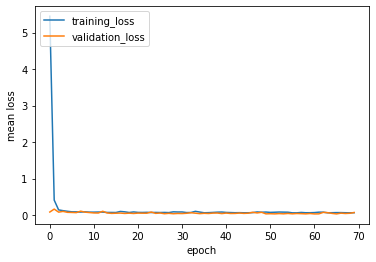

In [ ]:
#train model

model_cnn_reg, t_loss, val_loss = train(model_cnn_reg,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

MAE:  0.21744569
MSE:  0.07037796
Spearman correlation (Danceability, CNN):  0.12273356476644907


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use

Text(0, 0.5, 'y_pred')

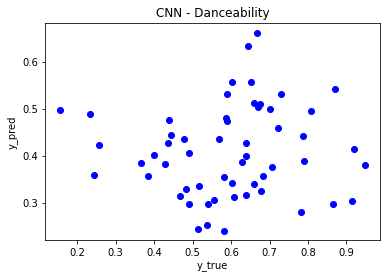

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_cnn_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
score_CNN.append(sp)
print("Spearman correlation (Danceability, CNN): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN - Danceability")
plt.xlabel("y_true")
plt.ylabel("y_pred")

In [ ]:
# mean scores
print("Mean score for LSTM: ", np.mean(score_LSTM))
print("Mean score for CNN: ", np.mean(score_CNN_1))

Mean score for LSTM:  0.2535693294637507
Mean score for CNN:  0.29391390462079753


# STEP 9

In [ ]:
import sys
sys.path.insert(1, '/kaggle/input/lstm-b')
#from lstm import LSTMBackbone
from sklearn.metrics import accuracy_score, confusion_matrix
#from modules import Classifier, MultitaskRegressor, Regressor


class EarlyStopping(object):
    def __init__(self, patience, mode="min", base=np.Inf):
        self.best = base
        self.patience = patience
        self.patience_left = patience
        self.mode = mode

    def stop(self, model, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Decrease patience if the metric hs not improved
        # Stop when patience reaches zero
        if not self.has_improved(value):
            self.patience_left-=1
        else:
            #keep the best value of the metric so far
            self.best = value
            #save the model with the best metric so far
            self.checkpoint(model)
        #if there is no patience left stop training process
        return self.patience_left == 0
    #A function to save best models parameters during training
    def checkpoint(self, model):
        torch.save(model.state_dict(), 'best_model.pth')

    #A function to load parameters of the best model during training
    def resume(self, model):
        model.load_state_dict(torch.load('best_model.pth'))

    def has_improved(self, value: float) -> bool:
        # TODO: YOUR CODE HERE
        # Check if the metric has improved
        return value < self.best


def training_loop(model, train_dataloader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch in train_dataloader:
        features, labels, lengths = batch
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        lengths = lengths.to(device)
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        outputs = model.forward(features.float(), lengths)
        # calculate loss
        loss = criterion(outputs, labels)
        # Run backward pass
        loss.backward()
        # Update the parameteres
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    #y_pred = torch.empty(0, dtype=torch.int64)
    #y_true = torch.empty(0, dtype=torch.int64)
    y_pred = torch.empty(0, dtype=torch.int64, device=device)
    y_true = torch.empty(0, dtype=torch.int64, device=device)
    with torch.no_grad():
        for num_batch, batch in enumerate(val_dataloader):
            features, labels, lengths = batch
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long, device=device)
            lengths = lengths.to(device)
            # TODO: YOUR CODE HERE
            # Run forward pass
            logits = model.forward(features.float(), lengths)
            # calculate loss
            loss = criterion(logits, labels)
            running_loss += loss.item()
            # Predict
            outputs = torch.argmax(logits, dim = 1)# Calculate the argmax of logits
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches

    return valid_loss, y_pred, y_true  # Return validation_loss and anything else you need


def overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion):
    epochs = 5000  # An absurd number of epochs
    # TODO: select a couple of batches from the dataloader
    batches = [next(iter(train_dataloader)) for i in range(2)]
    # TODO: Run the training loop for an absurd amount of epochs
    for epoch in range(epochs):
        training_loss = training_loop(model, batches, optimizer, criterion)
        if epoch%1000 is 0:
            print("Epoch:", epoch)
    b_loss, y_pred, y_true = validation_loop(model, batches, criterion)
    y_pred = torch.tensor(y_pred, device='cpu')
    y_true = torch.tensor(y_true, device='cpu')
    b_accuracy = accuracy_score(y_true, y_pred)
    print("Batch overfitting: loss = {}, acc = {}".format(b_loss, b_accuracy))


def train(model, train_dataloader, val_dataloader, optimizer, epochs, criterion, device="cuda", overfit_batch=False, patience = 20):
    t_loss = []
    val_loss = []
    val_acc = []
    model = model.to(device).float()
    early_stopping = EarlyStopping(patience, mode="min")
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion)
    else:
        for epoch in range(epochs):
            training_loss = training_loop(model, train_dataloader, optimizer, criterion)
            valid_loss, y_pred, y_true = validation_loop(model, val_dataloader, criterion)

            # TODO: Calculate and print accuracy score
            y_pred = torch.tensor(y_pred, device='cpu')
            y_true = torch.tensor(y_true, device='cpu')
            valid_accuracy = accuracy_score(y_true, y_pred)
            print(
                "Epoch {}: train loss = {}, valid loss = {}, valid acc = {}".format(
                    epoch, training_loss, valid_loss, valid_accuracy
                )
            )
            t_loss.append(training_loss)
            val_loss.append(valid_loss)
            val_acc.append(valid_accuracy)
            #check early stop criterion if early_stp is True
            if early_stp and early_stopping.stop(model, valid_loss):
                print("early stopping... ", epoch)
                early_stopping.resume(model)
                break
    #return trained model and losses during training
    return model, t_loss, val_loss, val_acc

In [ ]:
import torch
import torch.nn as nn

# CNN definition (Classification Task)

class CNNBackbone(nn.Module):

    def __init__(self, H, W):

        super(CNNBackbone, self).__init__()
        self.a = H
        self.b = W
        for i in range(4):
            self.a = ((self.a-6)//2) + 1
            self.b = ((self.b-6)//2) + 1

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.fc1 = nn.Linear(self.a*self.b*256, 10)  #78848
        self.dropout = nn.Dropout2d(p=0.1)

    #(n_samples, channels, height, width)
    def forward(self, x, lengths):
        x = x.unsqueeze(1)
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = self.fc1(output)
        return output

In [ ]:
# Train first model with mel spectrograms without beat sync

path = '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/'

# construct dataset
mel_specs = SpectrogramDataset(
         path,
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
#split dataset to train, val
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.2)

# construct test dataset
test_loader = SpectrogramDataset(
     path,
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_mel_spectrogram)
test_loader, _ = torch_train_val_split(test_loader, 32 ,32, val_size=0)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = True
input_dim = train_loader_mel.dataset.feats[0].shape

In [ ]:
# define model according to given code

model_f = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_f.parameters(),  lr=lr, weight_decay=weight_decay)

Retrain CNN classification model for Trasnfer Learning...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Epoch 0: train loss = 2.726103891586435, valid loss = 2.843386475245158, valid acc = 0.2386117136659436
Epoch 1: train loss = 2.0116366435741555, valid loss = 2.359126011530558, valid acc = 0.30151843817787416
Epoch 2: train loss = 1.6003359145131604, valid loss = 1.9900832653045655, valid acc = 0.3405639913232104
Epoch 3: train loss = 1.1445215693835555, valid loss = 2.1379716396331787, valid acc = 0.3405639913232104
Epoch 4: train loss = 0.9507101578959103, valid loss = 2.2791608333587647, valid acc = 0.3297180043383948
Epoch 5: train loss = 0.725010719278763, valid loss = 2.2443718830744426, valid acc = 0.3752711496746204
Epoch 6: train loss = 0.6253923511710661, valid loss = 2.6391525586446125, valid acc = 0.34273318872017355
Epoch 7: train loss = 0.3757003687065223, valid loss = 2.0679049094518027, valid acc = 0.37093275488069416
Epoch 8: train loss = 0.24461288377642632, valid loss = 1.9417554219563802, valid acc = 0.3947939262472885
Epoch 9: train loss = 0.18676614697123395, val

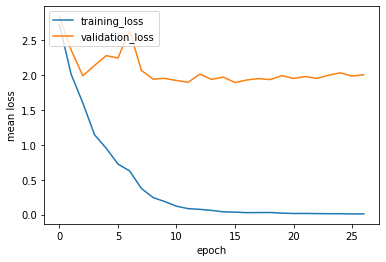

In [ ]:
print("Retrain CNN classification model for Transfer Learning...")
model_f, t_loss, val_loss, val_acc = train(model_f,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

In [ ]:
def training_loop(model, train_dataloader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch in train_dataloader:
        features, labels, lengths = batch
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.float, device=device)
        lengths = lengths.to(device)
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        outputs = model.forward(features.float(), lengths)
        # calculate loss
        loss = criterion(outputs, labels)
        # Run backward pass
        loss.backward()
        # Update the parameteres
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    #y_pred = torch.empty(0, dtype=torch.int64)
    #y_true = torch.empty(0, dtype=torch.int64)
    y_pred = torch.empty(0, dtype=torch.float, device=device)
    y_true = torch.empty(0, dtype=torch.float, device=device)
    with torch.no_grad():
        for num_batch, batch in enumerate(val_dataloader):
            features, labels, lengths = batch
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.float, device=device)
            lengths = lengths.to(device)
            # TODO: YOUR CODE HERE
            # Run forward pass
            outputs = model.forward(features.float(), lengths)
            # calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # Predict
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches
    return valid_loss, y_pred, y_true  # Return validation_loss and anything else you need


def train(model, train_dataloader, val_dataloader, optimizer, epochs, criterion, device="cuda", overfit_batch=False, patience = 20):
    t_loss = []
    val_loss = []
    model = model.to(device).float()
    early_stopping = EarlyStopping(patience, mode="min")
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion)
    else:
        for epoch in range(epochs):
            training_loss = training_loop(model, train_dataloader, optimizer, criterion)
            valid_loss, y_pred, y_true = validation_loop(model, val_dataloader, criterion)

            print(
                "Epoch {}: train loss = {}, valid loss = {}".format(
                    epoch, training_loss, valid_loss
                )
            )
            t_loss.append(training_loss)
            val_loss.append(valid_loss)
            #check early stop criterion if early_stp is True
            if early_stp and early_stopping.stop(model, valid_loss):
                print("early stopping... ", epoch)
                early_stopping.resume(model)
                break
    #return trained model and losses during training
    return model, t_loss, val_loss


In [ ]:
'''
Αφού εκαπιδεύοσυμε το μοντέλο CNN που επιλέξαμε ως καλύτερο,
φορτώνουμε τα βάρη του με την καλύτερη απόδοση (που είναι
αποθηκευμένα στο 'best_model.pth' μέσω του checkpoint() του
Early Stopping) σε ένα νέο μοντέλο, του οποίου αλλάζουμε το
τελευταίο επίπεδο ώστε να έχει output_dim = 1 και ξεκινάμε
την διαδικασία του Transfer Learning
'''
model_tf = CNNBackbone(input_dim[0], input_dim[1])
model_tf.load_state_dict(torch.load('best_model.pth'))
num_ftrs = model_tf.fc1.in_features
model_tf.fc1 = nn.Linear(num_ftrs, 1)

In [ ]:
path = path = '../input/patreco3-multitask-affective-music/data/multitask_dataset/'

mel_specs = MultitaskDataset(
    path,
    attr = 3,
    train=True,
    max_length=-1,
    read_spec_fn=read_mel_spectrogram)

train_loader_mel, val_loader_mel, test_loader = torch_train_val_test_split(mel_specs, 32 ,32, 32, val_size=.15, test_size=.15)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 10
early_stp = False
input_dim = train_loader_mel.dataset.feats[0].shape

In [ ]:
# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_tf.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.

Epoch 0: train loss = 0.07008624628186226, valid loss = 0.06136650840441386
Epoch 1: train loss = 0.06857554957270623, valid loss = 0.07794679701328278
Epoch 2: train loss = 0.06877050533890725, valid loss = 0.06965774670243263
Epoch 3: train loss = 0.07823721438646317, valid loss = 0.05341482410828272
Epoch 4: train loss = 0.06429396197199821, valid loss = 0.05997903645038605
Epoch 5: train loss = 0.06454267501831054, valid loss = 0.054095989714066185
Epoch 6: train loss = 0.061340107917785644, valid loss = 0.05733611745138963
Epoch 7: train loss = 0.05938083752989769, valid loss = 0.06097073356310526
Epoch 8: train loss = 0.06775652706623077, valid loss = 0.05476004568239053
Epoch 9: train loss = 0.057991039156913754, valid loss = 0.052669353783130646
Epoch 10: train loss = 0.05793948113918304, valid loss = 0.0543015773097674
Epoch 11: train loss = 0.0632453253865242, valid loss = 0.05615450876454512
Epoch 12: train loss = 0.06161070927977562, valid loss = 0.04421565681695938
Epoch 1

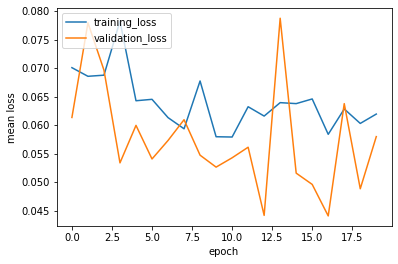

In [ ]:
#train model
model_tf, t_loss, val_loss = train(model_tf,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MAE:  0.20199862
MSE:  0.05671205
Spearman correlation (Danceability, CNN_tf):  0.1818476322982237


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

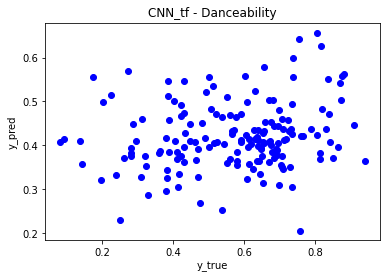

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_cnn_reg, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)
sp = stats.spearmanr(y_true, y_pred)[0]
print("Spearman correlation (Danceability, CNN_tf): ", sp)

# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN_tf - Danceability")
plt.xlabel("y_true")
plt.ylabel("y_pred")

# STEP 10

In [ ]:
import torch
import torch.nn as nn

# CNN definition for Multitask Learning (3 outputs)

class CNNBackbone(nn.Module):

    def __init__(self, H, W):

        super(CNNBackbone, self).__init__()
        self.a = H
        self.b = W
        for i in range(4):
            self.a = ((self.a-6)//2) + 1
            self.b = ((self.b-6)//2) + 1

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.fc1 = nn.Linear(self.a*self.b*256, 3)  #78848
        self.dropout = nn.Dropout2d(p=0.1)

    #(n_samples, channels, height, width)
    def forward(self, x, lengths):
        x = x.unsqueeze(1)
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = self.fc1(output)
        return output

In [ ]:
# Pytorch Dataset Class for creating the MultiTask dataset
class MultitaskDataset(Dataset):
    def __init__(self, path, train=True, max_length=-1, clsss_mapping=None, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        # Construct the path to label text file
        p = os.path.join(path, t)
        self.full_path = p
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        # get training or test files and also their label
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        # load spectrogram or chomagram or both from eaxh file
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        # keep length for each datum and max _length in dataset
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        # zero padd data to max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        # trasform labels to numbers
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('float')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = []
            l = l[0].split(',')
            label.append(l[1])
            label.append(l[2])
            label.append(l[3].strip('\n'))
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            fname = int(l[0])
            npy_file = '{}.fused.full.npy'.format(fname)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        # output = padded feature eg 128 * max_length for spectrogram, label, original feat lenght
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)


In [ ]:
def training_loop(model, train_dataloader, optimizer, criterion, device="cuda"):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for batch in train_dataloader:
        features, labels, lengths = batch
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.tensor(labels, dtype=torch.float, device=device)
        lengths = lengths.to(device)
        # zero grads in the optimizer
        optimizer.zero_grad()
        # run forward pass
        outputs = model.forward(features.float(), lengths)
        # calculate loss
        loss = criterion(outputs, labels)
        # Run backward pass
        loss.backward()
        # Update the parameteres
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    train_loss = running_loss / num_batches

    return train_loss  # Return train_loss and anything else you need


def validation_loop(model, val_dataloader, criterion, device="cuda"):
    model.eval()
    running_loss = 0.0
    num_batches = 0
    #y_pred = torch.empty(0, dtype=torch.int64)
    #y_true = torch.empty(0, dtype=torch.int64)
    y_pred = torch.empty(0, dtype=torch.float, device=device)
    y_true = torch.empty(0, dtype=torch.float, device=device)
    with torch.no_grad():
        for num_batch, batch in enumerate(val_dataloader):
            features, labels, lengths = batch
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.float, device=device)
            lengths = lengths.to(device)
            # TODO: YOUR CODE HERE
            # Run forward pass
            outputs = model.forward(features.float(), lengths)
            # calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            # Predict
            y_pred = torch.cat((y_pred, outputs))
            y_true = torch.cat((y_true, labels))
            num_batches += 1
    valid_loss = running_loss / num_batches
    return valid_loss, y_pred, y_true  # Return validation_loss and anything else you need


def train(model, train_dataloader, val_dataloader, optimizer, epochs, criterion, device="cuda", overfit_batch=False, patience = 20):
    t_loss = []
    val_loss = []
    model = model.to(device).float()
    early_stopping = EarlyStopping(patience, mode="min")
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, optimizer, criterion)
    else:
        for epoch in range(epochs):
            training_loss = training_loop(model, train_dataloader, optimizer, criterion)
            valid_loss, y_pred, y_true = validation_loop(model, val_dataloader, criterion)

            print(
                "Epoch {}: train loss = {}, valid loss = {}".format(
                    epoch, training_loss, valid_loss
                )
            )
            t_loss.append(training_loss)
            val_loss.append(valid_loss)
            #check early stop criterion if early_stp is True
            if early_stp and early_stopping.stop(model, valid_loss):
                print("early stopping... ", epoch)
                early_stopping.resume(model)
                break
    #return trained model and losses during training
    return model, t_loss, val_loss


In [ ]:
path = path = '../input/patreco3-multitask-affective-music/data/multitask_dataset/'

mel_specs = MultitaskDataset(
    path,
    train=True,
    max_length=-1,
    read_spec_fn=read_mel_spectrogram)

train_loader_mel, val_loader_mel, test_loader = torch_train_val_test_split(mel_specs, 32 ,32, 32, val_size=.1, test_size=.1)

# fix model hyperparameters
lr = 1e-4
weight_decay = 0
epochs = 70
early_stp = False
input_dim = train_loader_mel.dataset.feats[0].shape

In [ ]:
model_mt = CNNBackbone(input_dim[0], input_dim[1])

# Initialize AdamW
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_mt.parameters(),  lr=lr, weight_decay=weight_decay)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0: train loss = 3.89681528971113, valid loss = 0.71092888712883
Epoch 1: train loss = 0.27513775023920783, valid loss = 0.15399321168661118
Epoch 2: train loss = 0.12766070869462243, valid loss = 0.06665526237338781
Epoch 3: train loss = 0.10474572407788243, valid loss = 0.08149967528879642
Epoch 4: train loss = 0.09256983586940272, valid loss = 0.06368065811693668
Epoch 5: train loss = 0.0809709185670162, valid loss = 0.09573563002049923
Epoch 6: train loss = 0.08451709241188805, valid loss = 0.05817503668367863
Epoch 7: train loss = 0.07790533016467917, valid loss = 0.06947058066725731
Epoch 8: train loss = 0.08112003769854019, valid loss = 0.06448613665997982
Epoch 9: train loss = 0.06416663810096938, valid loss = 0.0846137385815382
Epoch 10: train loss = 0.07390080045523315, valid loss = 0.07071886584162712
Epoch 11: train loss = 0.08690998060949917, valid loss = 0.09723405726253986
Epoch 12: train loss = 0.06504989749398725, valid loss = 0.052532763220369816
Epoch 13: train 

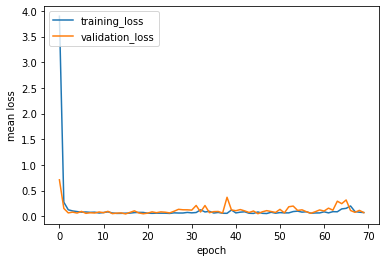

In [ ]:
#train model
model_mt, t_loss, val_loss = train(model_mt,train_loader_mel, val_loader_mel, optimizer, epochs, criterion)
#plot losses during learning
plt.plot(t_loss, label = 'training_loss')
plt.plot(val_loss, label = 'validation_loss')
plt.xlabel('epoch')
plt.ylabel('mean loss')
plt.legend( loc='upper left')
plt.show()

In [ ]:
# Report metrics on trained model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

test_loss, y_pred, y_true = validation_loop(model_mt, test_loader, criterion)
y_pred = torch.tensor(y_pred, device='cpu')
y_true = torch.tensor(y_true, device='cpu')
print("MAE: ", mean_absolute_error(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

valence_true = np.zeros(len(y_pred))
energy_true = np.zeros(len(y_pred))
danceability_true = np.zeros(len(y_pred))
valence_pred = np.zeros(len(y_pred))
energy_pred = np.zeros(len(y_pred))
danceability_pred = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    valence_true[i] = y_true[i][0]
    energy_true[i] = y_true[i][1]
    danceability_true[i] = y_true[i][2]
    valence_pred[i] = y_pred[i][0]
    energy_pred[i] = y_pred[i][1]
    danceability_pred[i] = y_pred[i][2]

sp_val = stats.spearmanr(valence_true, valence_pred)[0]
print("Spearman correlation (Valence, CNN_mt): ", sp_val)

sp_en = stats.spearmanr(energy_true, energy_pred)[0]
print("Spearman correlation (Energy, CNN_mt): ", sp_en)

sp_d = stats.spearmanr(danceability_true, danceability_pred)[0]
print("Spearman correlation (Danceability, CNN_mt): ", sp_d)

print("Mean Score for MultiTask CNN: ", np.mean([sp_val, sp_en, sp_d]))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


MAE:  0.23104703
MSE:  0.079741605
Spearman correlation (Valence, CNN_mt):  0.3738086239261793
Spearman correlation (Energy, CNN_mt):  0.6848473719266704
Spearman correlation (Danceability, CNN_mt):  0.3139665998553704
Mean Score for MultiTask CNN:  0.45754086523607346


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Text(0, 0.5, 'y_pred')

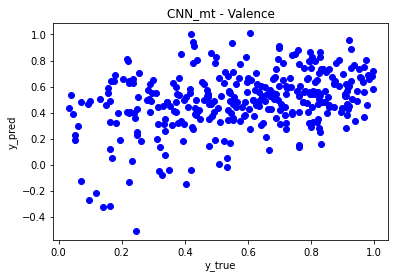

In [ ]:
# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN_mt - Valence")
plt.xlabel("y_true")
plt.ylabel("y_pred")

Text(0, 0.5, 'y_pred')

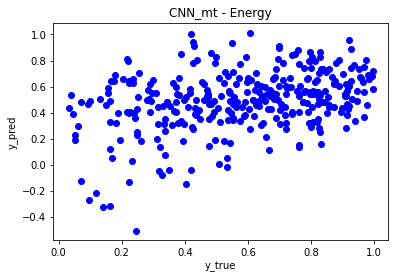

In [ ]:
# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN_mt - Energy")
plt.xlabel("y_true")
plt.ylabel("y_pred")

Text(0, 0.5, 'y_pred')

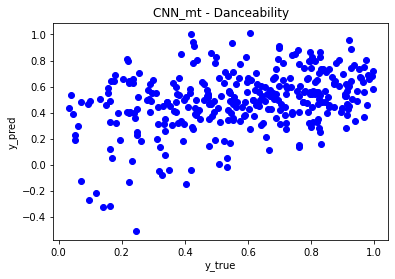

In [ ]:
# plt.style.use('seaborn-whitegrid')
plt.plot(y_true , y_pred, 'o', color='blue');
plt.title("CNN_mt - Danceability")
plt.xlabel("y_true")
plt.ylabel("y_pred")